In [1]:
from astropy.stats import sigma_clipped_stats
from photutils import find_peaks
import numpy as np
import matplotlib.pyplot as plt
import warnings
from astropy.modeling import models, fitting
from astropy.stats import sigma_clipped_stats
from photutils.datasets import make_100gaussians_image
from photutils import find_peaks
#%matplotlib inline
from astropy.io import fits
import pickle

import sys
sys.path.append('../Extraction_Software/')
import reduction_py2 as red

%matplotlib inline

In [3]:
def extract_profiles(infile,outfile='',box_size=(10,22),nlines=-1,
                     verbose=True,debug=False,keep_all=False,threshold=300,crop=[],row_offset_to_standard=0,
                    show_final_lines=True,savelines=False,loadlines=False,autosave=False,show_postage_stamps=True):
    '''
    PURPOSE
    -----------
    Computes the FWHM of each laser frequency comb line, and the average FWHM.
    Uses Gaussian fitting to each line. Divides CCD into sections and reports fit
    for each section.
    
    
    CALLING EXAMPLE
    -----------
    >python, foc('file.txt')
    

    INPUTS
    -----------
    infile: string or list or array
        Specifies the path to image(s). A single image may be given as a string. Otherwise, provide
        a list or array of string.
        
    
    KEYWORDS
    -----------
    outfile: string
        Specifies the path to a text file that will contain a record of FWHM measurements for each section.
        Will create new file if needed. Otherwise, it writes to the end of it. If outfile is left blank,
        no file will be written.
    
    box_size: int
        Number of pixels around the comb lines that should be excised and analyzed. Should be smaller than the
        comb line separation but larger than the PSF's FWHM.
        
    nlines: int
        Maximum number of lines to analyze within a chunk. If set to -1, it will analyze all lines. If a greater
        value is specified, it will draw every nlines as evenly spaced as possible over the section (possibly
        missing a few extra in the lower right of the section if the number of lines / nlines has a large remainder).
    
    cosmic: bool
        Flag for running lacosmic to elimate cosmic rays from the image. May not be necessary for short exposures.
        
    verbose: bool
        Flag for verbosity.
        
    debug: bool
        Flag for providing simulated .npy data rather than fits files
        
        
    OUTPUTS
    -----------
    
    
    METHOD
    -----------
    
    
    HISTORY
    -----------
    Created by Allen Davis 2017.
    '''
    
    assert not(savelines and loadlines)
    assert (savelines or loadlines)
    
    #---Open file(s)---
    assert (type(infile) is list and all([type(el) is str for el in infile])) or (type(infile) is str)

    # Force to list type object
    batch = True
    if type(infile) is str:
        batch = False
        infile = [infile]

    # YADA YADA
    # data.shape should be n,10k,10k
    data = [red.quickReduction(f) for f in infile]
        
#     if not crop == []:
#         data = [d[crop[0][0]:crop[0][1],crop[1][0]:crop[1][1]] for d in data]
    
    # Make 2D mask  
    mask = np.ones(data[0].shape) # 1s where we want to block
    mask[crop[0][0]:crop[0][1],crop[1][0]:crop[1][1]] = 0
    mask = np.where(mask==1,True,False)
    
    #---Identify lines---
    const = 2.*np.sqrt(2.*np.log(2.)) #factor that converts sigma to FWHM ~2.3
    
    if type(box_size) is int:
        xpad = ypad = int(np.ceil(box_size/2.))
    else:
        xpad = int(np.ceil(box_size[0]/2.))
        ypad = int(np.ceil(box_size[1]/2.))
    
    im = data[0]
    if savelines:
        # Use peak-finding algorithm to identify lines
        if verbose: print 'Threshold: %.f'%threshold

        tbl = find_peaks(im, threshold, box_size=box_size, mask=mask)
        if verbose:
            old_len = len(tbl)
            print '%d peaks initially found'%old_len

        if len(tbl) == 0:
            print 'No peaks found.'
            #continue

    # Fit gaussians to lines
        if verbose: print 'Fitting gaussian profiles to lines...'

        profiles = []
        rows = []
        cols = []
        chunks = []
        n_elim = 0
        for j,line in enumerate(tbl):
            # Excise a box_size chunk around the peak
            x_c, y_c = line['x_peak'],line['y_peak']

            chunk = im[y_c-ypad:y_c+ypad,x_c-xpad:x_c+xpad]
            n_high = sum(sum(chunk > 100))

            if n_high < 25:
                n_elim += 1
                continue

            if np.max(chunk) > 30000:
                n_elim += 1
                continue

            #Note that x_mean and y_mean are relative to the chunk, not to sect, or im
            #We are fixing theta so it doesn't flip by pi rad and give negative answers, or by pi/2 and flip x & y
            p_init = models.Gaussian2D(amplitude=line['peak_value'], x_mean=chunk.shape[1], y_mean=chunk.shape[0],  
                                       x_stddev=4./const,y_stddev=16./const,theta=0.)#,
                                       #fixed={'theta':True}) # consider setting bounds for positive sigma
            fit_p = fitting.LevMarLSQFitter()
            y, x = np.mgrid[:chunk.shape[0], :chunk.shape[1]]
            with warnings.catch_warnings():
                # Ignore model linearity warning from the fitter
                warnings.simplefilter('ignore')
                p = fit_p(p_init, x, y, chunk)

            resids = chunk - p(x, y)

            if abs(np.mean(resids)) > 500:
                n_elim += 1
#                     print abs(np.mean(resids)),'is too high'
                continue
            if p.x_stddev < 2 or p.x_stddev > 12:
#                     print 'x_stddev of %.f is o.o.b.'%p.x_stddev[0]
                n_elim += 1
                continue
            if p.y_stddev < 8/2.3 or p.y_stddev > 25/2.3:
#                     print 'y_stddev of %.f is o.o.b.'%p.y_stddev[0]
                n_elim += 1
                continue
            if np.std(resids) > 200:
#                     print 'resids std of %.f is too great'%np.std(resids)
                n_elim += 1
                continue

            profiles.append(p)
            rows.append(y_c)
            cols.append(x_c)
            chunks.append(chunk)

        if len(chunks)==0:
            print 'All lines were eliminated.'
            #continue

        # What fraction of lines will be fit?
        if nlines==-1:
            every = 1
            if verbose: print 'Every peak will be analyzed.'
        else:
            every = int(np.floor(len(chunks)/float(nlines)))
            if every==0:
                every = 1
            print 'every=',every
            if verbose: print '%d peaks will be analyzed.'%nlines

        profiles_good = []
        rows_good = []
        cols_good = []
        n_man_elim = 0
        for p,row,col,chunk in zip(profiles[::every],rows[::every],cols[::every],chunks[::every]):

            y, x = np.mgrid[:chunk.shape[0], :chunk.shape[1]]

            resids = chunk - p(x, y)

            # Uncomment for plots of the fits, but be sure to put a stop in there somewhere
            if show_postage_stamps:
                plt.figure(figsize=(7, 2.5))
                plt.subplot(1, 3, 1)
                vmin, vmax = np.min(chunk),np.max(chunk)
                plt.imshow(chunk,interpolation='None',vmin=vmin,vmax=vmax)
                plt.colorbar()
                plt.title("r%d, c%d"%(row,col),fontsize=8)
                plt.subplot(1, 3, 2)
                plt.imshow(p(x, y),interpolation='None',vmin=vmin,vmax=vmax)
                plt.colorbar()
                plt.title("Model, stddev = %.3f"%p.x_stddev.value,fontsize=8)
                plt.subplot(1, 3, 3)
                plt.imshow(resids,interpolation='None')
                plt.colorbar()
                plt.title("Residual: mean: %f"%np.mean(resids),fontsize=8)
                plt.show()
#             plt.savefig('./figs/expres/im%d_line%d.png'%(i,j),dpi=100)
#             plt.close()
#           
            plt.show()

            if keep_all:
                profiles_good.append(p)
                rows_good.append(row)
                cols_good.append(col)
            else:
                ans = raw_input('Keep line? y/n: ')
                while True:
                    if ans=='y':
                        profiles_good.append(p)
                        rows_good.append(row)
                        cols_good.append(col)
                        break
                    elif ans=='n':
                        n_man_elim += 1
                        break
                    ans = raw_input("Type 'y' or 'n': ")

#             profiles.append(p)
#             rows.append(y_c)
#             cols.append(x_c)
        
        if verbose: print '%d line fits were rejected automatically. %d line fits'\
                          ' were rejected manually. In total, %d lines have saved '\
                            'measurements.'%(n_elim,n_man_elim,len(profiles_good))
        if show_final_lines:
            plt.figure()
            vmin = np.percentile(im,2)
            vmax = np.percentile(im,95)
            plt.imshow(im,interpolation='None',cmap='Greys_r',vmin=vmin,vmax=vmax)
            for r in crop[0]:
                plt.axhline(r,color='r')
            for c in crop[1]:
                plt.axvline(c,color='r')
            plt.plot(cols_good, rows_good, ls='none', color='cyan',
                 marker='x', ms=5, lw=1.5)
#                 plt.xlim(0,sect.shape[0])
#                 plt.ylim(sect.shape[1],0)
            plt.colorbar()
            plt.show()
        
        ans = raw_input('Save lines? save/no: ')
        while True:
            if ans=='save':
                if batch:
                    f_out = 'batch_'+infile[0][:infile[0].rfind('.fits')]+'_lines.p'
                else:
                    f_out = infile[0][:infile[0].rfind('.fits')]+'_lines.p'
                pickle.dump((rows,cols),
                        open(f_out,'wb'))
                print 'pickle saved as '+f_out
                break
            elif ans=='no':
                break
            ans = raw_input("Type 'save' or 'no': ") 
        
    elif loadlines:
        profiles = []
        rows = []
        cols = []
        chunks = []
        if not row_offset_to_standard == 0:
            print 'WARNING, OFFSET ROWS'
        y_cs,x_cs = pickle.load(open(loadlines))
        for x_c,y_c in zip(x_cs,y_cs):
            
            y_c += row_offset_to_standard
            
            chunk = im[y_c-ypad:y_c+ypad,x_c-xpad:x_c+xpad]

            #Note that x_mean and y_mean are relative to the chunk, not to sect, or im
            #We are fixing theta so it doesn't flip by pi rad and give negative answers, or by pi/2 and flip x & y
            p_init = models.Gaussian2D(amplitude=np.max(chunk), x_mean=chunk.shape[1], y_mean=chunk.shape[0],  
                                       x_stddev=4./const,y_stddev=16./const,theta=0.)#,
                                       #fixed={'theta':True}) # consider setting bounds for positive sigma
            fit_p = fitting.LevMarLSQFitter()
            y, x = np.mgrid[:chunk.shape[0], :chunk.shape[1]]
            with warnings.catch_warnings():
                # Ignore model linearity warning from the fitter
                warnings.simplefilter('ignore')
                p = fit_p(p_init, x, y, chunk)

            resids = chunk - p(x, y)
            
            # Comment out if need be
#             plt.figure(figsize=(7, 2.5))
#             plt.subplot(1, 3, 1)
#             vmin, vmax = np.min(chunk),np.max(chunk)
#             plt.imshow(chunk,interpolation='None',vmin=vmin,vmax=vmax)
#             plt.colorbar()
#             plt.title("r%d, c%d"%(y_c,x_c),fontsize=8)
#             plt.subplot(1, 3, 2)
#             plt.imshow(p(x, y),interpolation='None',vmin=vmin,vmax=vmax)
#             plt.colorbar()
#             plt.title("Model, stddev = %.3f"%p.x_stddev.value,fontsize=8)
#             plt.subplot(1, 3, 3)
#             plt.imshow(resids,interpolation='None')
#             plt.colorbar()
#             plt.title("Residual: mean: %f"%np.mean(resids),fontsize=8)
#             plt.show()
            
            profiles.append(p)
            rows.append(y_c)
            cols.append(x_c)
            chunks.append(chunk)
        
        if autosave:
            f_out = infile[0][:infile[0].rfind('.fits')]+'.p'
            pickle.dump((np.array([profiles]),np.array([rows]),np.array([cols])),
                    open(f_out,'wb'))
            print 'pickle saved as '+f_out
        else:
            ans = raw_input('Save pickle? save/no: ')
            while True:
                if ans=='save':
                    if batch:
                        f_out = 'batch_'+infile[0][:infile[0].rfind('.fits')]+'.p'
                    else:
                        f_out = infile[0][:infile[0].rfind('.fits')]+'.p'
                        pickle.dump((np.array([profiles]),np.array([rows]),np.array([cols])),
                            open(f_out,'wb'))
                    print 'pickle saved as '+f_out
                    break
                elif ans=='no':
                    break
                ans = raw_input("Type 'save' or 'no': ")  
            
    print 'Everything is complete.'
    plt.close()
    return np.array([profiles]),np.array([rows]),np.array([cols])

In [6]:
# lines files created by Nov 18 4:30pm use this crop: [[5000,9000],[3200-360,10560-2000]]; eg ./expres_focus_images/Nov18/DCT_6972_lines.p
# ./expres_focus_images/Nov18/DCT_6988_lines.p uses this crop: [[4000,5000],[3200-360,10560-2000]]; 

# nums = np.arange(6658,6680)
# nums = np.arange(6680,6689)
# nums = np.arange(6787,6788)
nums = np.arange(7552,7553) 

date = 'Dec10'
mode = 2

for n in nums:
    try:
        if mode==1:
            print 'ID-ing lines...'
            all_profiles,\
            all_rows,\
            all_cols = extract_profiles(infile='./expres_focus_images/%s/DCT_%d.fits'%(date,n),
                                   crop=[[4000,8600],[3000,8500]],threshold=1000,nlines=80,
                                        show_final_lines=False,box_size=(35,35),row_offset_to_standard=0,
                                       keep_all=(  True),
                                       savelines=( True),
                                        autosave=( True),
                                        loadlines=not'./expres_focus_images/%s/DCT_%d_lines.p'%(date,n),
                                       show_postage_stamps=True)
        elif mode==2:
            print 'saving lines...'
            all_profiles,\
            all_rows,\
            all_cols = extract_profiles(infile='./expres_focus_images/%s/DCT_%d.fits'%(date,n),
                                   crop=[[4000,8600],[3000,10560-1600]],threshold=1000,nlines=80,
                                        show_final_lines=False,box_size=(35,35),row_offset_to_standard=0,
                                       keep_all=( not True),
                                       savelines=(not True),
                                        autosave=(not False),
                                        loadlines='./expres_focus_images/%s/DCT_%d_lines.p'%(date,n),
                                       show_postage_stamps=False)
    #rdiv=[5500,6500],cdiv=[3500,7000]
    #'./expres_focus_images/Nov20/DCT_7145_lines.p'
    except IOError:
        print 'file %d not found'%n

saving lines...
pickle saved as ./expres_focus_images/Dec10/DCT_7552.p
Everything is complete.


# STOP HERE

In [ ]:
def correct_params(x_in,y_in,theta_in):
    theta = theta_in*180./np.pi #convert to deg
    const = 2.*np.sqrt(2.*np.log(2.))
    x = abs(x_in*const) # ensure positive
    y = abs(y_in*const) # ensure positive
    

    # x should be smaller than y. If not, rotate by 90 deg and reverse x and y
    if x > y:
        dum = y
        y = x
        x = dum
        theta = (theta + 90)
        
    theta = theta%360

    # Restrict domain of theta to Q1 and Q4 (if up is 0)
    if theta > 90 and theta < 270:
        theta = (theta + 180)%360
        
    # Now theta is either between 0 and 90 (fine) or between 270 and 360 (not ok).
    # If the latter, make between -90 and 0.
    if theta > 270:
        theta = theta - 360
    
    return x,y,theta
    
    

In [ ]:
def plot_profiles(profiles,rows,cols,remove_outliers=False,title='',plot=True):
    
    out = np.array([correct_params(p.x_stddev,p.y_stddev,p.theta) for p in profiles])
    x_fwhm, y_fwhm, theta = out[:,0], out[:,1], out[:,2]
    

    theta_std = np.std(theta)
    
    if remove_outliers:
        locs = np.where((theta < np.percentile(theta,90)) & ((theta > np.percentile(theta,10))))

        x_fwhm, y_fwhm, theta = x_fwhm[locs], y_fwhm[locs], theta[locs]
        rows, cols = rows[locs], cols[locs]
    
    if plot:
        f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex='col', sharey='row')

        plt.figure(figsize=(10,3))
    #     plt.subplot(411)
        ax1.plot(rows,x_fwhm,'ko')
        ax1.set_xlabel('ROW')
        ax1.set_ylabel('dispersion FWHM')
    #     ax1.set_ylim(0,20)
    #     plt.show()

    #     plt.subplot(412)
        ax2.plot(cols,x_fwhm,'ko')
        ax2.set_xlabel('COLUMN')
        ax2.set_ylabel('dispersion FWHM')
    #     ax2.set_ylim(0,20)

    #     plt.subplot(421)
        ax3.plot(rows,theta,'ko')
        ax3.set_xlabel('ROW')
        ax3.set_ylabel('theta')
    #     plt.ylim(0,20)

    #     plt.subplot(422)
        ax4.plot(cols,theta,'ko')
        ax4.set_xlabel('COLUMN')
        ax4.set_ylabel('theta')
    #     ax4.set_ylim(0,20)

        if not title=='':
            f.suptitle(title,fontsize=12)
    #     f.subplots_adjust(top=0.88)
    #     f.tight_layout()

        plt.show()
        plt.close()
    
    return np.mean(x_fwhm), np.mean(theta)

In [42]:
# dictionary. Format is: filename, focus rotations relative to the same standard. 

files1 = {'./expres_focus_images/Nov16/20171116_12000x10600_6593.p':0.,
        './expres_focus_images/Nov16/20171116_12000x10600_6594.p':3.,
        './expres_focus_images/Nov16/20171116_12000x10600_6595.p':6.,
        './expres_focus_images/Nov16/20171116_12000x10600_6596.p':9.,
         './expres_focus_images/Nov16/20171116_12000x10600_6597.p':12.,
        }

files2 = {'./expres_focus_images/Nov16/20171116_12000x10600_6601.p':0.,
         './expres_focus_images/Nov16/20171116_12000x10600_6602.p':0.25,
         './expres_focus_images/Nov16/20171116_12000x10600_6603.p':0.5,
         './expres_focus_images/Nov16/20171116_12000x10600_6604.p':0.75,
         './expres_focus_images/Nov16/20171116_12000x10600_6605.p':1.0,
         './expres_focus_images/Nov16/20171116_12000x10600_6606.p':1.25,
         './expres_focus_images/Nov16/20171116_12000x10600_6607.p':1.5,
         './expres_focus_images/Nov16/20171116_12000x10600_6609.p':2.,
         './expres_focus_images/Nov16/20171116_12000x10600_6610.p':2.25,}

files3 = {'./expres_focus_images/Nov17/DCT_6645.p':30.5,
          './expres_focus_images/Nov17/DCT_6646.p':35.5,
         './expres_focus_images/Nov17/DCT_6647.p':40.5} #number of turns

files4 = {'./expres_focus_images/Nov17/DCT_6650.p':0.,
          './expres_focus_images/Nov17/DCT_6651.p':1,
          './expres_focus_images/Nov17/DCT_6652.p':2,
          './expres_focus_images/Nov17/DCT_6653.p':3,
          } #number of turns

files5 = {
          './expres_focus_images/Nov17/DCT_6659.p':-3,
          './expres_focus_images/Nov17/DCT_6660.p':-2,
          './expres_focus_images/Nov17/DCT_6661.p':-1,
          './expres_focus_images/Nov17/DCT_6662.p':0,
          './expres_focus_images/Nov17/DCT_6663.p':1,
          './expres_focus_images/Nov17/DCT_6664.p':2,
          './expres_focus_images/Nov17/DCT_6665.p':3,
          './expres_focus_images/Nov17/DCT_6666.p':4,
          './expres_focus_images/Nov17/DCT_6667.p':5,
          './expres_focus_images/Nov17/DCT_6668.p':6,
          './expres_focus_images/Nov17/DCT_6669.p':7,
          './expres_focus_images/Nov17/DCT_6670.p':8,
          './expres_focus_images/Nov17/DCT_6671.p':9,
          './expres_focus_images/Nov17/DCT_6672.p':10,
          './expres_focus_images/Nov17/DCT_6673.p':11,
          './expres_focus_images/Nov17/DCT_6674.p':12,
          './expres_focus_images/Nov17/DCT_6675.p':13,
          './expres_focus_images/Nov17/DCT_6676.p':14,
          './expres_focus_images/Nov17/DCT_6677.p':15,
          './expres_focus_images/Nov17/DCT_6678.p':16,
          './expres_focus_images/Nov17/DCT_6679.p':17,
          } #'./expres_focus_images/Nov17/DCT_6658.p':0,



#6598 - 6600 are too wide/split to measure lines.
# 6609 has light leak

In [ ]:
files = files5

mean_fwhms = []
mean_thetas = []
focus_poses = []
for f in files.keys():
    focus_pos = files[f]
    
    all_p,\
    all_r,\
    all_c = pickle.load(open(f,'rb'))
    
    mean_fwhm, mean_theta = plot_profiles(all_p[0],all_r[0],all_c[0],remove_outliers=True,
                             title=str(focus_pos),plot=False)
    
    mean_fwhms.append(mean_fwhm)
    mean_thetas.append(mean_theta)
    focus_poses.append(focus_pos)

mean_fwhms = [x for _,x in sorted(zip(focus_poses,mean_fwhms))]
mean_thetas = [x for _,x in sorted(zip(focus_poses,mean_thetas))]
focus_poses = sorted(focus_poses)

plt.figure()
plt.plot(focus_poses,mean_fwhms)
# plt.errorbar(focus_poses,mean_fwhms,yerr=[0 for _ in mean_fwhms])
plt.xlabel('turns away from detector')
plt.ylabel('mean fwhm')

plt.figure()
plt.plot(focus_poses,mean_thetas,'bo-')
plt.xlabel('turns away from detector')
plt.ylabel('mean theta')

    

In [235]:
# def analyze_profiles(all_profiles,histograms=False):
#     const = 2.*np.sqrt(2.*np.log(2.))
#     all_x_fwhms = []
#     all_y_fwhms = []
#     all_thetas = []
#     all_x_fwhms_err = []
#     all_y_fwhms_err = []
#     all_thetas_err = []
#     report = ''
#     # Loop over all images
#     for i in range(all_profiles.shape[0]):
#         report += '\n'+'{:*^53}'.format('IMAGE %d'%i)+'\n'
#         report += '{:<10}'.format('zone') + '{:<9}'.format('x_fwhm') + '{:<6}'.format('err') +\
#                     '{:<9}'.format('y_fwhm') + '{:<7}'.format('err') + \
#                     '{:<8}'.format('theta') + '{:<5}'.format('err') +'\n'
#         x_fwhms = []
#         y_fwhms = []
#         thetas = []
#         x_fwhms_err = []
#         y_fwhms_err = []
#         thetas_err = []

#         profiles = all_profiles[i,j]

#         # Reverse the definitions for x and y if theta is close to 90 deg
# #             x_fwhm = np.array([abs(p.x_stddev.value*const) for p in profiles])
# #             y_fwhm = np.array([abs(p.y_stddev.value*const) for p in profiles])

#         x_fwhm_raw = [p.x_stddev.value for p in profiles] # still in sigma
#         y_fwhm_raw = [p.y_stddev.value for p in profiles] # still in sigma
#         theta_raw = [p.theta.value for p in profiles] # still in rads

#         corrected = np.array([correct_params(x,y,t) for x,y,t in zip(x_fwhm_raw,y_fwhm_raw,theta_raw)])

#         x_fwhms.append(np.mean(corrected[:,0]))
#         y_fwhms.append(np.mean(corrected[:,1]))
#         thetas.append(np.mean(corrected[:,2]))
#         x_fwhms_err.append(np.std(corrected[:,0]))
#         y_fwhms_err.append(np.std(corrected[:,1]))
#         thetas_err.append(np.std(corrected[:,2]))
#         if histograms:
#             plt.figure(figsize=(9, 2.5))
#             plt.subplot(1, 3, 1)
#             plt.hist(corrected[:,0])
#             plt.xlabel('x_fwhm');
#             plt.title('image %d, section %d'%(i,j))
#             plt.subplot(1, 3, 2)
#             plt.hist(corrected[:,1])
#             plt.xlabel('y_fwhm');
#             plt.title('image %d, section %d'%(i,j))
#             plt.subplot(1, 3, 3)
#             plt.hist(corrected[:,2])
#             plt.xlabel('theta');
#             plt.title('image %d, section %d'%(i,j))
#             plt.show()
#             plt.close()
#         report += '{:<10}'.format('Sec. %d:'%j) + '{:>6}'.format('%.2f'%np.mean(corrected[:,0])) +\
#                 u" \u00B1 "+'{:>4}'.format('%.2f'%np.std(corrected[:,0])) + '{:>8}'.format('%.2f'%np.mean(corrected[:,1])) +\
#                 u" \u00B1 "+'{:>4}'.format('%.2f'%np.std(corrected[:,1]))+'{:>8}'.format('%.2f'%np.mean(corrected[:,2]))+\
#                 u" \u00B1 "+'{:>4}'.format('%.2f'%np.std(corrected[:,2])) + '\n' 
#     report += '{:<12}'.format('Overall:') + '{:>4}'.format('%.2f'%np.mean(x_fwhms)) +\
#               '{:>15}'.format('%.2f'%np.mean(y_fwhms)) + '{:>15}'.format('%.2f'%np.mean(thetas))+'\n'
#     all_x_fwhms.append(x_fwhms)
#     all_y_fwhms.append(y_fwhms)
#     all_thetas.append(thetas)
#     all_x_fwhms_err.append(x_fwhms_err)
#     all_y_fwhms_err.append(y_fwhms_err)
#     all_thetas_err.append(thetas_err)
#     all_x_fwhms = np.array(all_x_fwhms)
#     all_y_fwhms = np.array(all_y_fwhms)
#     all_x_fwhms_err = np.array(all_x_fwhms_err)
#     all_y_fwhms_err = np.array(all_y_fwhms_err)
#     all_thetas = np.array(all_thetas)
#     all_thetas_err = np.array(all_thetas_err)
    
#     print report
#     return report, (all_x_fwhms, all_x_fwhms_err, all_y_fwhms, all_y_fwhms_err, all_thetas, all_thetas_err)

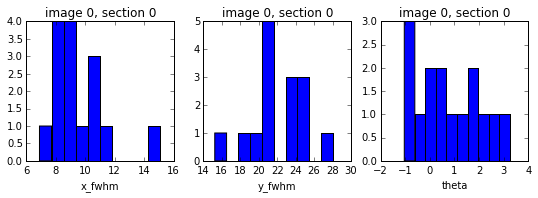


***********************IMAGE 0***********************
zone      x_fwhm   err   y_fwhm   err    theta   err  
Sec. 0:     9.50 ± 1.92   21.96 ± 2.98    0.78 ± 1.30
Overall:    9.50          21.96           0.78



In [25]:
report122, all_params = analyze_profiles(all_profiles,histograms=True)

In [26]:
print report118,report119,report120,report122

NameError: name 'report118' is not defined

In [ ]:
report118

In this test, the larger fwhms are being over reported. My guess is that it due to both the contamination from nearby lines, and the significant background level. Raising the floor (with a bias) will make the lines look wider. So I should bias subtract first.

In [ ]:
# Alignment via row alignment

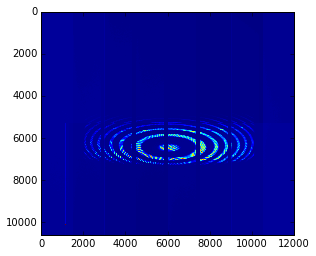

In [140]:
plt.imshow(images[0])

In [268]:
def fit_specific_line(data,lines=[[6299,7262],[5721,7263]],box_size=15,
                    verbose=True,sub_back=0.,mask_size=30):
   
    # data should be a single
        
    #---Identify LFC lines---
    const = 2.*np.sqrt(2.*np.log(2.)) #factor that converts sigma to FWHM ~2.3
#     mean, median, std = sigma_clipped_stats(data, sigma=3.0)
    threshold = 10000#median + (10.0 * np.sqrt(median))
    
    if verbose: print 'Threshold: %.f'%threshold
    if verbose: print 'Finding lines.'
        
#     if mask==[]:
#         mask = np.ones(data.shape)
#     else:
#         dum = mask
#         del mask
#         mask = np.zeros(data.shape)
#         mask[dum[0][0]:dum[0][1],dum[1][0]:dum[1][1]] = 1
#         mask = np.where(mask==1,False,True) # mask is defined weirdly
#         plt.imshow(mask)

    # Build mask around lines you want to measure
    mask = np.ones(data.shape) # 1 means ignore
#     mask = np.where(mask==1,False,True)
    pad = int(np.ceil(mask_size/2.))
    for line in lines:
        mask[line[0]-pad:line[0]+pad,line[1]-pad:line[1]+pad] = 0
    mask = np.where(mask==1,True,False)
#     plt.imshow(mask)
#     return mask
    
    print 'Finding peaks'
    tbl = find_peaks(data, threshold, box_size=box_size,mask=mask)
    print '%d peaks found'%len(tbl)
    
    for line in lines:
        plt.figure()
        plt.imshow(data[line[0]-pad:line[0]+pad,line[1]-pad:line[1]+pad],interpolation='None',cmap='Greys_r')
        plt.plot(tbl['x_peak'], tbl['y_peak'], ls='none', color='cyan',
             marker='x', ms=5, lw=1.5)
        plt.plot(line[1],line[0],ls='none',color='red')
        plt.xlim(line[1]-pad,line[1]+pad)
        plt.ylim(line[0]-pad,line[0]+pad) #reversed
        plt.title('%s'%str(line))
        plt.colorbar()
        plt.show()
    
    return tbl



    for line in r,c:
        
        # Make sure the line was identified
        
        return tbl
#         if debug:
#             plt.figure()
#             plt.imshow(sect,interpolation='None',cmap='Greys_r')
#             plt.plot(tbl['x_peak'], tbl['y_peak'], ls='none', color='cyan',
#                  marker='x', ms=5, lw=1.5)
#             plt.plot(tbl['x_peak'][::every], tbl['y_peak'][::every], ls='none', color='red',
#                  marker='x', ms=5, lw=1.5)
# #                 plt.xlim(0,sect.shape[0])
# #                 plt.ylim(sect.shape[1],0)
#             plt.title('Section %d'%i)
#             plt.colorbar()
#             plt.show()
#             plt.savefig('debug.pdf')

        # Fit gaussians to lines
        if verbose: print 'Fitting gaussian profiles to lines...'

        sect_profiles = []
        for j,line in enumerate(tbl[::every]):
            # Excise a box_size chunk around the peak
            x_c, y_c = line['x_peak'],line['y_peak']

            if type(box_size) is int:
                xpad = ypad = int(np.ceil(box_size/2.))
            else:
                xpad = int(np.ceil(box_size[0]/2.))
                ypad = int(np.ceil(box_size[1]/2.))

            chunk = sect[y_c-ypad:y_c+ypad,x_c-xpad:x_c+xpad]

            #Note that x_mean and y_mean are relative to the chunk, not to sect, or im
            #We are fixing theta so it doesn't flip by pi rad and give negative answers, or by pi/2 and flip x & y
            p_init = models.Gaussian2D(amplitude=line['peak_value'], x_mean=chunk.shape[1], y_mean=chunk.shape[0],  
                                       x_stddev=4./const,y_stddev=16./const,theta=0.)#,
                                       #fixed={'theta':True}) # consider setting bounds for positive sigma
            fit_p = fitting.LevMarLSQFitter()
            y, x = np.mgrid[:chunk.shape[0], :chunk.shape[1]]
            with warnings.catch_warnings():
                # Ignore model linearity warning from the fitter
                warnings.simplefilter('ignore')
                p = fit_p(p_init, x, y, chunk)

            resids = chunk - p(x, y)
            if abs(np.mean(resids)) > 500:
                print abs(np.mean(resids)),'is too high'
                continue

            sect_profiles.append(p)

            # Uncomment for plots of the fits, but be sure to put a stop in there somewhere
            plt.figure(figsize=(8, 2.5))
            plt.subplot(1, 3, 1)
            vmin, vmax = np.min(chunk),np.max(chunk)
            plt.imshow(chunk,interpolation='None',vmin=vmin,vmax=vmax)
            plt.colorbar()
            plt.title("Data")
            plt.subplot(1, 3, 2)
            plt.imshow(p(x, y),interpolation='None',vmin=vmin,vmax=vmax)
            plt.colorbar()
            plt.title("Model, stddev = %.3f"%p.x_stddev.value)
            plt.subplot(1, 3, 3)
            plt.imshow(resids,interpolation='None')
            plt.colorbar()
            plt.title("Residual: mean: %f"%np.mean(resids))
            plt.savefig('./figs/expres/section%d_%d.png'%(i,j))
            plt.close()
#                 return
        all_sect_profiles.append(sect_profiles)    
    all_profiles.append(all_sect_profiles)
    print 'Everything is complete. Returning all_profiles. The dimensions of this are [n,m,q_i]; n=number of images, '\
          'm=number of sections, and q_i=number of lines measured in section i.'
    return np.array(all_profiles),data_raw

Threshold: 10000
Finding lines.
Finding peaks
8 peaks found


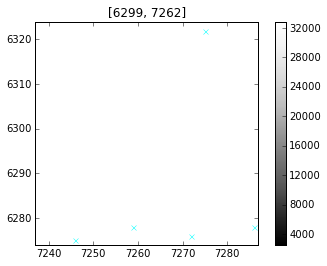

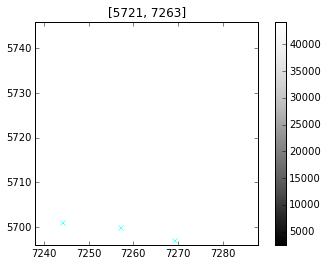

In [269]:
tbl = fit_specific_line(images[0],lines=[[6299,7262],[5721,7263]],box_size=(10,22),mask_size=50)
#[[6000,7000],[6000,7000]]
#mask=[[5000,8000],[2000,10000]]
# mask = (col,rows)

In [257]:
tbl

x_peak,y_peak,peak_value
int64,int64,uint16
7269,5697,44238
7257,5700,43556
7244,5701,43911
7246,6275,25656
7272,6276,27912
7259,6278,27148
7286,6278,27837
7275,6322,32870


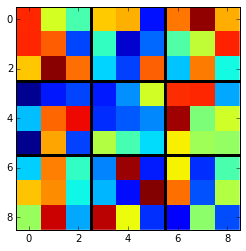

In [121]:
import matplotlib.pyplot as plt
%matplotlib inline

cdiv=[3,6]
rdiv=[3,6]

data = np.random.random((9,9))
plt.imshow(data,interpolation='None',vmin=0,vmax=1)

for c in cdiv:
    plt.axvline(c-0.5,color='k',linewidth=3)
    
for r in rdiv:
    plt.axhline(r-0.5,color='k',linewidth=3)

In [106]:
sections = divide_image(data,rdiv,cdiv)

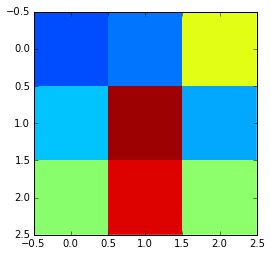

In [57]:
# row,col

for i in range(len(rdiv)):
    for j in range(len(cdiv)):
        rloc
        if i==0 and j==0:
            sub = data[0:rdiv[0],0:cdiv[0]]
        elif j==0:
            sub = data[0:rdiv[0],0:cdiv[0]]
        plt.imshow(sub,interpolation='None',vmin=0,vmax=1)


In [19]:
infile = ['','we']


###### raise TypeError

In [32]:
np.array(([1,2],[1,2],[4,3])).shape

(3, 2)

In [69]:
np.split(data,4)

ValueError: array split does not result in an equal division

In [62]:
help(np.split)

Help on function split in module numpy.lib.shape_base:

split(ary, indices_or_sections, axis=0)
    Split an array into multiple sub-arrays.
    
    Parameters
    ----------
    ary : ndarray
        Array to be divided into sub-arrays.
    indices_or_sections : int or 1-D array
        If `indices_or_sections` is an integer, N, the array will be divided
        into N equal arrays along `axis`.  If such a split is not possible,
        an error is raised.
    
        If `indices_or_sections` is a 1-D array of sorted integers, the entries
        indicate where along `axis` the array is split.  For example,
        ``[2, 3]`` would, for ``axis=0``, result in
    
          - ary[:2]
          - ary[2:3]
          - ary[3:]
    
        If an index exceeds the dimension of the array along `axis`,
        an empty sub-array is returned correspondingly.
    axis : int, optional
        The axis along which to split, default is 0.
    
    Returns
    -------
    sub-arrays : list of nd

x_peak y_peak   peak_value 
------ ------ -------------
   233      0 27.4778521972
   236      1  27.339519624
   289     22 35.8532759965
   442     31 30.2399941373
     1     40 35.5482863002
    89     59 41.2190469279
     7     70 33.2880647048
   258     75 26.5624808518
   463     80 28.7588206692
   182     93 38.0885687202


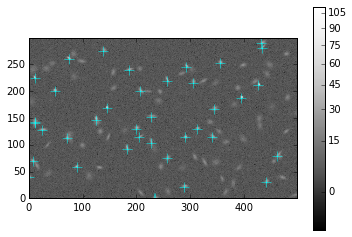

In [142]:

data = make_100gaussians_image()
mean, median, std = sigma_clipped_stats(data, sigma=3.0)
threshold = median + (10.0 * std)
tbl = find_peaks(data, threshold, box_size=5)
print(tbl[:10])    # print only the first 10 peaks

# import matplotlib.pyplot as plt
# from astropy.visualization import SqrtStretch
# from astropy.visualization.mpl_normalize import ImageNormalize
norm = ImageNormalize(stretch=SqrtStretch())
plt.imshow(data, cmap='Greys_r', origin='lower', norm=norm)
plt.plot(tbl['x_peak'], tbl['y_peak'], ls='none', color='cyan',
         marker='+', ms=10, lw=1.5)
plt.xlim(0, data.shape[1]-1)
plt.ylim(0, data.shape[0]-1)
plt.colorbar();

In [149]:
print tbl

x_peak y_peak   peak_value 
------ ------ -------------
   233      0 27.4778521972
   236      1  27.339519624
   289     22 35.8532759965
   442     31 30.2399941373
     1     40 35.5482863002
    89     59 41.2190469279
     7     70 33.2880647048
   258     75 26.5624808518
   463     80 28.7588206692
   182     93 38.0885687202
   ...    ...           ...
   427    211 76.3605030769
   305    216  28.961033169
   257    219 38.3108157896
    11    224 55.7684684034
   187    239 36.3685694452
   293    245 43.6640339664
   356    252  35.776163952
    74    260 51.0609727151
   139    275 29.3923788459
   434    280 30.8879763226
   433    289 33.4119443197
Length = 38 rows


In [144]:
help(find_peaks)

Help on function find_peaks in module photutils.detection.core:

find_peaks(data, threshold, box_size=3, footprint=None, mask=None, border_width=None, npeaks=inf, subpixel=False, error=None, wcs=None)
    Find local peaks in an image that are above above a specified
    threshold value.
    
    Peaks are the maxima above the ``threshold`` within a local region.
    The regions are defined by either the ``box_size`` or ``footprint``
    parameters.  ``box_size`` defines the local region around each pixel
    as a square box.  ``footprint`` is a boolean array where `True`
    values specify the region shape.
    
    If multiple pixels within a local region have identical intensities,
    then the coordinates of all such pixels are returned.  Otherwise,
    there will be only one peak pixel per local region.  Thus, the
    defined region effectively imposes a minimum separation between
    peaks (unless there are identical peaks within the region).
    
    When using subpixel precision

In [184]:
from astropy.modeling import models, fitting

In [194]:
del p_init
del fit_p

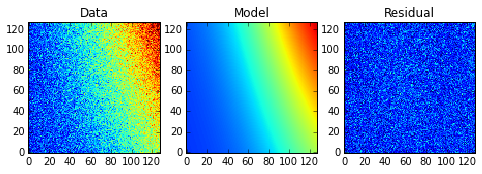

In [203]:
import warnings
import numpy as np
import matplotlib.pyplot as plt
from astropy.modeling import models, fitting

# Generate fake data
np.random.seed(0)
y, x = np.mgrid[:128, :128]
z = 2. * x ** 2 - 0.5 * x ** 2 + 1.5 * x * y - 1.
z += np.random.normal(0., 0.1, z.shape) * 50000.

# Fit the data using astropy.modeling
# p_init = models.Polynomial2D(degree=2)
p_init = models.Gaussian2D(amplitude=1, x_mean=0, y_mean=0)
fit_p = fitting.LevMarLSQFitter()

with warnings.catch_warnings():
    # Ignore model linearity warning from the fitter
    warnings.simplefilter('ignore')
    p = fit_p(p_init, x, y, z)

# Plot the data with the best-fit model
plt.figure(figsize=(8, 2.5))
plt.subplot(1, 3, 1)
plt.imshow(z, origin='lower', interpolation='nearest', vmin=-1e4, vmax=5e4)
plt.title("Data")
plt.subplot(1, 3, 2)
plt.imshow(p(x, y), origin='lower', interpolation='nearest', vmin=-1e4,
           vmax=5e4)
plt.title("Model")
plt.subplot(1, 3, 3)
plt.imshow(z - p(x, y), origin='lower', interpolation='nearest', vmin=-1e4,
           vmax=5e4)
plt.title("Residual")

In [575]:
help(models.Gaussian2D)

Help on class Gaussian2D in module astropy.modeling.functional_models:

class Gaussian2D(astropy.modeling.core.Fittable2DModel)
 |  Two dimensional Gaussian model.
 |  
 |  Parameters
 |  ----------
 |  amplitude : float
 |      Amplitude of the Gaussian.
 |  x_mean : float
 |      Mean of the Gaussian in x.
 |  y_mean : float
 |      Mean of the Gaussian in y.
 |  x_stddev : float or None
 |      Standard deviation of the Gaussian in x before rotating by theta. Must
 |      be None if a covariance matrix (``cov_matrix``) is provided. If no
 |      ``cov_matrix`` is given, ``None`` means the default value (1).
 |  y_stddev : float or None
 |      Standard deviation of the Gaussian in y before rotating by theta. Must
 |      be None if a covariance matrix (``cov_matrix``) is provided. If no
 |      ``cov_matrix`` is given, ``None`` means the default value (1).
 |  theta : float, optional
 |      Rotation angle in radians. The rotation angle increases
 |      counterclockwise.  Must be N

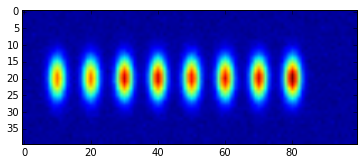

In [464]:
# Make fake data
y, x = np.mgrid[:40, :100]
p_init = models.Gaussian2D()
const = 2*np.sqrt(2*np.log(2))
dat = p_init.evaluate(x,y,100,10,20,4/const,10/const,0)
for el in range(1,8):
    dat += p_init.evaluate(x,y,100+(np.random.random()*30),10+(el*10),20,4/const,10/const,0)
dat += np.random.normal(0., 0.1, dat.shape) * 10.

plt.imshow(dat)

# np.save('dat_nonunif',dat)

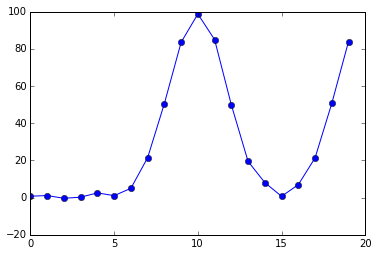

In [466]:
plt.plot(dat[20,0:20],'bo-')

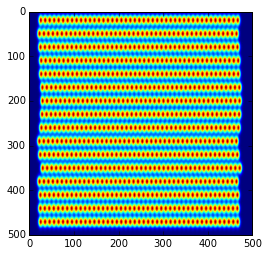

In [645]:
# Make fake data
y, x = np.mgrid[:500, :500]

p_init = models.Gaussian2D()
const = 2*np.sqrt(2*np.log(2))
x_fwhm, y_fwhm = 4, 18

dat = p_init.evaluate(x,y,0,10,20,x_fwhm/const,y_fwhm/const,0) # dummy: setting equal to 0 everywhere

for r in range(16):
    offset = np.random.uniform(10)
    for c in range(45):
        dat += p_init.evaluate(x,y,40000,
                               20+offset+(c*10),20+(r*30),
                               x_fwhm/const,y_fwhm/const,0)

# dat += np.random.normal(0., 0.1, dat.shape) * 10.
dat += 600 #bias
dat = np.random.normal(loc=dat,scale=np.sqrt(dat))

plt.imshow(dat)
# np.save('dat_nonunif_full',dat)
np.save('dat_xfwhm%d_yfwhm%d'%(x_fwhm,y_fwhm),dat)

# np.save('dat_nonunif_full_poor_focus',dat)


In [641]:
dat

array([[ 636.52136046,  597.74007854,  621.51222612, ...,  618.23620567,
         608.54896801,  636.66888646],
       [ 583.52001167,  584.01294742,  621.57290274, ...,  635.0094421 ,
         602.61405739,  598.25110481],
       [ 640.507637  ,  589.04392617,  601.33036787, ...,  611.0248332 ,
         598.42933813,  608.03325905],
       ..., 
       [ 646.22288803,  616.25311353,  551.96658467, ...,  594.50883244,
         591.78379896,  569.5975519 ],
       [ 630.68421963,  620.92289202,  634.92572076, ...,  639.08823253,
         596.38025367,  615.95886851],
       [ 601.53007853,  612.83213264,  637.46762856, ...,  596.12154855,
         613.10950593,  597.05575099]])

In [305]:
np.random.uniform(10)

6.478854842787448

In [297]:
x.shape

(5000, 5000)

In [256]:
mean, median, std = sigma_clipped_stats(dat, sigma=3.0)
threshold = median + (10.0 * std)
print 'Threshold: %.f'%threshold
tbl = find_peaks(dat, threshold, box_size=7)
print 'Peaks found: %d'%len(tbl)

Threshold: 50
Peaks found: 8


In [209]:
print help(p_init)

Help on Gaussian2D in module astropy.modeling.functional_models object:

class Gaussian2D(astropy.modeling.core.Fittable2DModel)
 |  Two dimensional Gaussian model.
 |  
 |  Parameters
 |  ----------
 |  amplitude : float
 |      Amplitude of the Gaussian.
 |  x_mean : float
 |      Mean of the Gaussian in x.
 |  y_mean : float
 |      Mean of the Gaussian in y.
 |  x_stddev : float or None
 |      Standard deviation of the Gaussian in x before rotating by theta. Must
 |      be None if a covariance matrix (``cov_matrix``) is provided. If no
 |      ``cov_matrix`` is given, ``None`` means the default value (1).
 |  y_stddev : float or None
 |      Standard deviation of the Gaussian in y before rotating by theta. Must
 |      be None if a covariance matrix (``cov_matrix``) is provided. If no
 |      ``cov_matrix`` is given, ``None`` means the default value (1).
 |  theta : float, optional
 |      Rotation angle in radians. The rotation angle increases
 |      counterclockwise.  Must be 